# Captcha Recognition in Images using CRNN with CTC Loss




## Overview

This code demonstrates a deep learning-based approach for recognizing text in images. The core architecture used is a Convolutional Recurrent Neural Network (CRNN) with the Connectionist Temporal Classification (CTC) loss. Let's break down what this code does and the significance of its components:

## Model Architecture

### Convolutional Recurrent Neural Network (CRNN)

The CRNN is a hybrid architecture that combines convolutional neural networks (CNNs) and recurrent neural networks (RNNs). This combination makes it particularly well-suited for tasks involving sequence recognition in images, such as text recognition. The model consists of the following components:

- **Convolutional Layers:** These layers apply a series of convolution operations to the input images. Convolution helps extract meaningful features from the images, such as edges and patterns.

- **Recurrent Layers (LSTM):** Bidirectional Long Short-Term Memory (LSTM) layers are used for sequence modeling. LSTMs are capable of capturing dependencies in sequential data, making them effective for recognizing text sequences within images.

- **Output Layer:** The final layer uses a softmax activation function to predict the probabilities of each character in the output sequence. This is crucial for recognizing individual characters in the text.

- **CTC Loss:** The model is trained using the Connectionist Temporal Classification (CTC) loss function, which is essential for sequence-to-sequence tasks like text recognition.

## Connectionist Temporal Classification (CTC) Loss

### What is CTC Loss?

CTC loss is a specialized loss function designed for sequence recognition tasks where the alignment between input and output sequences is not known beforehand. In text recognition, for example, the length of the text may not match the length of the input image. CTC loss addresses this challenge by enabling the model to learn the alignment automatically.
ctc_alignment_steps.svg


### How CTC Loss Works

- **Label Encoding:** In text recognition, the label is typically a sequence of characters corresponding to the text in the image.

- **CTC Loss Computation:** CTC loss computes the likelihood of the true label sequence given the input image and the predicted sequence of characters.

- **Handling Varying Lengths:** Importantly, CTC loss can handle cases where the length of the predicted sequence doesn't exactly match the length of the true label. It introduces a special "blank" symbol and aligns the characters accordingly.

- **Training Objective:** The training objective is to maximize the likelihood of the correct label sequence, taking into account all possible alignments.

### Purpose of CTC Loss

CTC loss serves a critical role in text recognition tasks by allowing models to:

- Recognize text in images without requiring explicit character-level alignment during training.
- Handle varying text lengths, making it suitable for scenarios with different text lengths in images.
- Train end-to-end models that directly output character sequences without relying on intermediate steps like text localization.

## Project Purpose

This code brings together the CRNN architecture and CTC loss to build a robust text recognition model. It demonstrates how to preprocess image data, train the model, and visualize both the training history and predictions. The model's flexibility in handling varying text lengths and its ability to learn alignment make it a valuable tool for various applications, such as OCR (Optical Character Recognition), automated data entry, and more.

Feel free to adapt this code for your specific text recognition tasks and explore improvements in model architecture and hyperparameters.

## Importing Libraries and Frameworks

This code block begins by importing necessary Python libraries and TensorFlow components. These libraries and components are crucial for building and training the Convolutional Recurrent Neural Network (CRNN) model with Connectionist Temporal Classification (CTC) loss for text recognition in images.


In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!unzip -xq '.../images.zip'

## Data Preprocessing and Dataset Creation

In this section, the code block accomplishes the following tasks:

1. **Constants Definition**: It defines several constants crucial for data preprocessing and model training:
   - `image_height` and `image_width`: The desired height and width of the captcha images.
   - `batch_size`: The batch size for training the model.

2. **Image Directory and File Paths**: It prepares the dataset by:
   - Determining the directory containing the captcha images extracted from a ZIP file.
   - Creating a list of file paths to all the captcha images within the directory.
   - Extracting the labels from the image label file and storing them in the `labels` list.

3. **Maximum Captcha Length**: It computes the maximum length of any captcha in the dataset. This information is useful for defining the model's output layer.

4. **Character Set**: It creates a set of all unique characters present in the labels. This set will be used to define the output classes for the model.

5. **Image Preprocessing Function**: It defines a function, `preprocess_image`, responsible for reading, decoding, and resizing the captcha images. The images are converted to grayscale.

6. **Preprocessing Images and Labels**: It processes the images by applying the `preprocess_image` function to each image path. Simultaneously, it encodes the labels as sequences of integers.

7. **Creating TensorFlow Datasets**: It creates TensorFlow datasets from the preprocessed images and encoded labels. These datasets will be used for training and validation.


This section is crucial for preparing the dataset and defining the data pipeline required for training the OCR (Optical Character Recognition) model.


In [ ]:
import os
import cv2

# Create a list of image file paths and corresponding labels
def image_paths_labels(image_dir, label_file):
  with open(label_file, 'r') as file:
    lines = file.readlines()
    image_paths = [os.path.join(image_dir, line.split(' ')[0]) for line in lines]
    labels = [line.split(' ')[1].strip() for line in lines]
  return image_paths, labels

# Define a function to preprocess an image
def preprocess_image(image_path, img_height, img_width):
    # Read the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded correctly
    if img is None:
        raise FileNotFoundError(f"Image not found or unable to load: {image_path}")

    # Resize the image
    resized_image = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(resized_image, (5, 5), 0)

    # Apply adaptive thresholding to enhance text
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply sharpening filter
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(binary, -1, kernel)

    # Increase contrast
    alpha = 2.0  # Simple contrast control
    beta = 0     # Simple brightness control
    contrasted = cv2.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

    # Invert the colors (white to black and black to white)
    inverted = cv2.bitwise_not(contrasted)

    # Convert to tensor
    img_tensor = tf.convert_to_tensor(inverted, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=-1)  # Add the channel dimension
    return img_tensor

def padding(encoded_labels, max_label_length=6):
  # Pad labels to the maximum length and convert to tensors
  padded_labels = [[10] * (max_label_length - len(label)) + label for label in encoded_labels]
  label_tensors = [tf.convert_to_tensor(label, dtype=tf.int32) for label in padded_labels]
  return label_tensors

In [ ]:
train_image_dir = '/content/content/train'
train_label_file = '.../train.txt'
val_image_dir = '/content/content/val'
val_label_file = '.../val.txt'

train_image_paths, train_labels = image_paths_labels(train_image_dir, train_label_file)
val_image_paths, val_labels = image_paths_labels(val_image_dir, val_label_file)

# Create a set of all unique characters in the labels
all_possible_characters = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'}

# Define constants
image_height, image_width = 50, 200
batch_size = 16

# Preprocess images and labels
train_images = [preprocess_image(image_path, image_height, image_width) for image_path in train_image_paths]
val_images = [preprocess_image(image_path, image_height, image_width) for image_path in val_image_paths]

# Convert each label to a list of its integer digits
train_encoded_labels = [[int(char) for char in label] for label in train_labels]
val_encoded_labels = [[int(char) for char in label] for label in val_labels]

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, padding(train_encoded_labels, max_label_length=6))).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, padding(val_encoded_labels, max_label_length=6))).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Visualizing Random Samples from the Dataset

In this section, the code defines a Python function and demonstrates how to use it for visualizing random samples from a dataset.

### `visualize_random_samples` Function

This function serves the following purposes:

- **Visualization**: It visualizes random samples from a given dataset, allowing you to inspect the captcha images and their corresponding labels.

- **Arguments**:
  - `dataset` (tf.data.Dataset): The dataset containing image-label pairs.
  - `int_to_char` (dict): A dictionary that maps integer labels to characters, enabling label decoding.
  - `num_samples` (int): The number of random samples to visualize.

- **Returns**: None

The function performs the following steps:

1. **Create Dataset Iterator**: It creates an iterator for the provided dataset using the `iter` function. This iterator will allow us to iterate through the dataset and access random samples.

2. **Iterate and Visualize**: Inside a loop that runs for `num_samples` iterations, the function does the following:
   - Retrieves the next random sample from the dataset using the iterator.
   - Decodes the label by converting the integer label values to characters using the `int_to_char` mapping.
   - Displays the captcha image alongside its label:
     - The image is displayed using Matplotlib with grayscale color mapping.
     - The label is shown as the image title.

3. **Example Usage**: An example usage of the `visualize_random_samples` function is provided. It visualizes five random samples from the `validation_dataset` and uses the `int_to_char` mapping to decode and display their labels.

This section helps you visually inspect and verify the quality of the data in your dataset, ensuring that the images and labels are correctly paired. It's a valuable step in understanding your data before training the OCR model.



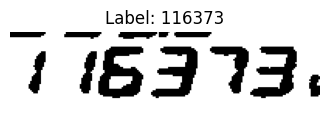

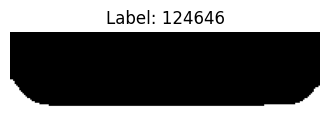

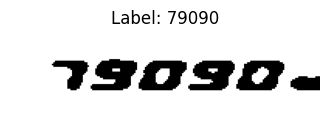

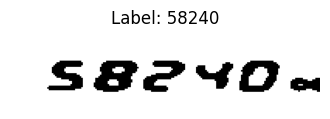

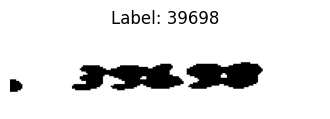

In [ ]:
def visualize_batch_samples(dataset, num_samples=5):
    """
    Visualize samples from the first batch of a dataset.

    Args:
        dataset (tf.data.Dataset): The dataset containing image-label pairs.
        num_samples (int): The number of samples to visualize.

    Returns:
        None
    """
    # Create an iterator for the dataset and get the first batch
    dataset_iter = iter(dataset)
    images, labels = next(dataset_iter)

    # Ensure num_samples does not exceed the batch size
    num_samples = min(num_samples, images.shape[0])

    # Iterate through the samples in the batch and visualize them
    for i in range(num_samples):
        image = images[i].numpy()
        label = labels[i].numpy()

        # Replace -1 with blank space and convert to string
        label_str = ''.join(['' if x == 10 else str(x) for x in label])

        # Display the image and label
        plt.figure(figsize=(4, 2))
        plt.imshow(image[:, :, 0], cmap='gray')
        plt.title("Label: " + label_str)
        plt.axis('off')
        plt.show()

# Example usage:
visualize_batch_samples(val_dataset, num_samples=5)

## OCR Model Architecture

In this section, we define and describe the architecture of the Optical Character Recognition (OCR) model for captcha image recognition. The code presented below outlines the various components of the model and how they are configured.

### Model Architecture

The OCR model consists of the following components:

#### Input Layer
- Input Shape: `(image_height, image_width, 1)`
- Purpose: The input layer defines the shape of the input data, which corresponds to grayscale captcha images. Each image is `image_height` pixels in height and `image_width` pixels in width.

#### Standardization Layer
- Purpose: This layer rescales pixel values to be within the [0, 1] range. It's common practice to standardize input data to facilitate model training.

#### Transposition Layer
- Purpose: The `Lambda` layer transposes the input tensor to the shape `(None, image_width, image_height, 1)` to ensure that the time dimension aligns with the width of the image.

#### Convolutional Layers
- Configuration: Multiple pairs of Conv2D layers with ReLU activation and Batch Normalization are applied. MaxPooling2D layers with appropriate strides are used for downsampling.
- Purpose: Convolutional layers extract features from the input images. Batch Normalization helps stabilize training, and MaxPooling2D reduces spatial dimensions.

#### Reshape Layer
- Purpose: This layer reshapes the tensor to `(image_width // 8, (image_height // 4) * 256)`, which is important for the subsequent recurrent layers. It essentially "flattens" the spatial dimensions while retaining the time dimension.

#### Dense Layer
- Configuration: A Dense layer with ReLU activation is applied.
- Purpose: The Dense layer processes the flattened features extracted by the convolutional layers.

#### Recurrent Layers (Bidirectional LSTM)
- Configuration: Two Bidirectional LSTM layers with dropout are applied. These layers are recurrent and process sequential data.
- Purpose: Bidirectional LSTMs capture temporal dependencies in the data, making them suitable for recognizing characters in captcha images. They process data in both forward and backward directions, improving the model's ability to learn from sequences.

#### Output Layer (CTC)
- Configuration: A Dense layer with a softmax activation function is applied. The number of units in this layer corresponds to the number of unique characters in the dataset plus one (for the CTC blank label).
- Purpose: The output layer produces character predictions. The CTC (Connectionist Temporal Classification) loss is used to align predicted characters with ground truth labels. The `ctc_loss` function is defined to calculate the CTC loss for each element in a batch. It takes as input the true labels `(samples, max_string_length)`, predicted sequences `(samples, time_steps, num_categories)`, input sequence lengths `(samples, 1)`, and label sequence lengths `(samples, 1)`. The function computes the CTC loss for each element in the batch and returns a tensor with the CTC loss for each element.

### Model Compilation

The model is compiled using the Adam optimizer and a custom CTC loss function. CTC loss measures the dissimilarity between predicted sequences and ground truth sequences, considering variable alignment.

### Summary

The model summary, which provides a concise overview of the model architecture, is displayed at the end of the code cell. It includes details about layer types, output shapes, and the number of parameters.

This OCR model is designed for recognizing odometers from car dashboard images.


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, Bidirectional, LSTM, Dense, Lambda, Rescaling, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.backend import ctc_batch_cost, ctc_decode

# Define the input layer
input_data = Input(shape=(image_height, image_width, 1), name='input_image')

# Standardize values to be in the [0, 1] range
x = Rescaling(1./255)(input_data)

# Transpose the tensor to shape (None, image_width, image_height, 1)
x = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]), name="transpose")(x)

# Convolutional layers
x = Conv2D(64, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name="pool1")(x)

x = Conv2D(128, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name="pool2")(x)

x = Conv2D(256, (3, 3), activation="relu", kernel_initializer=tf.keras.initializers.he_normal(), padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 1), name="pool3")(x) # Pooling over time dimension

x = Reshape(target_shape=(image_width // 8, (image_height // 4) * 256), name="reshape")(x)
x = Dense(128, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = Dropout(0.2)(x)

# Recurrent layers (Bidirectional LSTM)
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)

# Output layer (CTC)
output = Dense(len(all_possible_characters) + 1, activation='softmax')(x)

# Create the model
model = Model(inputs=input_data, outputs=output, name="OCR_model")

model.summary()

Model: "OCR_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 50, 200, 1)]      0         
                                                                 
 rescaling (Rescaling)       (None, 50, 200, 1)        0         
                                                                 
 transpose (Lambda)          (None, 200, 50, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 64)       640       
                                                                 
 batch_normalization (Batch  (None, 200, 50, 64)       256       
 Normalization)                                                  
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 64)       0         
                                                         

In [ ]:
def ctc_loss(y_true, y_pred):
    batch_size = tf.shape(y_true)[0]
    input_length = tf.fill([batch_size, 1], tf.shape(y_pred)[1])
    label_length = tf.fill([batch_size, 1], 6)
    loss = ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00003), loss=ctc_loss)

## Training the Model

Now, let's train our OCR model. We'll run training for a maximum of 20 epochs. The training progress will be monitored based on the val loss, The best weights from training will be restored.



In [ ]:
from keras.callbacks import ModelCheckpoint

num_epochs = 50

checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Path to save the model file
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Only save the best weights
    verbose=1  # Verbosity mode, 1 for progress messages
)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=checkpoint_callback
)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 43.0383
Epoch 1: val_loss improved from inf to 41.65394, saving model to best_model.h5
7/7 [==============================] - 15s 383ms/step - loss: 43.0383 - val_loss: 41.6539


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
5/7 [====================>.........] - ETA: 0s - loss: 36.5164
Epoch 2: val_loss improved from 41.65394 to 36.19349, saving model to best_model.h5
7/7 [==============================] - 0s 44ms/step - loss: 35.7640 - val_loss: 36.1935
Epoch 3/50
3/7 [===========>..................] - ETA: 0s - loss: 29.4325

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/7 [====================>.........] - ETA: 0s - loss: 28.4470
Epoch 3: val_loss improved from 36.19349 to 30.84215, saving model to best_model.h5
7/7 [==============================] - 0s 43ms/step - loss: 27.8272 - val_loss: 30.8422
Epoch 4/50
6/7 [========================>.....] - ETA: 0s - loss: 22.5021
Epoch 4: val_loss improved from 30.84215 to 27.06994, saving model to best_model.h5
7/7 [==============================] - 0s 66ms/step - loss: 22.3950 - val_loss: 27.0699
Epoch 5/50
6/7 [========================>.....] - ETA: 0s - loss: 19.1463
Epoch 5: val_loss improved from 27.06994 to 24.66479, saving model to best_model.h5
7/7 [==============================] - 2s 248ms/step - loss: 19.0633 - val_loss: 24.6648


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 6/50
6/7 [========================>.....] - ETA: 0s - loss: 17.5316
Epoch 6: val_loss improved from 24.66479 to 23.28224, saving model to best_model.h5
7/7 [==============================] - 2s 177ms/step - loss: 17.4688 - val_loss: 23.2822


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7/50
6/7 [========================>.....] - ETA: 0s - loss: 16.6308
Epoch 7: val_loss improved from 23.28224 to 22.54430, saving model to best_model.h5
7/7 [==============================] - 1s 149ms/step - loss: 16.5774 - val_loss: 22.5443
Epoch 8/50
3/7 [===========>..................] - ETA: 0s - loss: 16.4312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 16.3506
Epoch 8: val_loss improved from 22.54430 to 22.20777, saving model to best_model.h5
7/7 [==============================] - 1s 157ms/step - loss: 16.3039 - val_loss: 22.2078
Epoch 9/50
3/7 [===========>..................] - ETA: 0s - loss: 16.3290

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 16.2069
Epoch 9: val_loss improved from 22.20777 to 22.12345, saving model to best_model.h5
7/7 [==============================] - 1s 154ms/step - loss: 16.1414 - val_loss: 22.1235
Epoch 10/50
3/7 [===========>..................] - ETA: 0s - loss: 16.2686

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 16.1080
Epoch 10: val_loss did not improve from 22.12345
7/7 [==============================] - 1s 151ms/step - loss: 16.0334 - val_loss: 22.2099
Epoch 11/50
5/7 [====================>.........] - ETA: 0s - loss: 15.9603
Epoch 11: val_loss did not improve from 22.12345
7/7 [==============================] - 1s 149ms/step - loss: 15.8581 - val_loss: 22.3872
Epoch 12/50
5/7 [====================>.........] - ETA: 0s - loss: 15.8533
Epoch 12: val_loss did not improve from 22.12345
7/7 [==============================] - 0s 30ms/step - loss: 15.7340 - val_loss: 22.5621
Epoch 13/50
5/7 [====================>.........] - ETA: 0s - loss: 15.7186
Epoch 13: val_loss did not improve from 22.12345
7/7 [==============================] - 1s 30ms/step - loss: 15.6016 - val_loss: 22.6995
Epoch 14/50
6/7 [========================>.....] - ETA: 0s - loss: 15.5192
Epoch 14: val_loss did not improve from 22.12345
7/7 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 67ms/step - loss: 15.0842 - val_loss: 21.9557
Epoch 19/50
7/7 [==============================] - ETA: 0s - loss: 14.9613
Epoch 19: val_loss improved from 21.95565 to 21.65216, saving model to best_model.h5
7/7 [==============================] - 1s 176ms/step - loss: 14.9613 - val_loss: 21.6522
Epoch 20/50
3/7 [===========>..................] - ETA: 0s - loss: 15.2432

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 15.0351
Epoch 20: val_loss improved from 21.65216 to 21.40143, saving model to best_model.h5
7/7 [==============================] - 1s 163ms/step - loss: 14.9558 - val_loss: 21.4014


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 21/50
5/7 [====================>.........] - ETA: 0s - loss: 15.0112
Epoch 21: val_loss improved from 21.40143 to 21.11103, saving model to best_model.h5
7/7 [==============================] - 0s 46ms/step - loss: 14.8968 - val_loss: 21.1110
Epoch 22/50
5/7 [====================>.........] - ETA: 0s - loss: 14.9085
Epoch 22: val_loss improved from 21.11103 to 20.83630, saving model to best_model.h5
7/7 [==============================] - 0s 45ms/step - loss: 14.8073 - val_loss: 20.8363
Epoch 23/50
7/7 [==============================] - ETA: 0s - loss: 14.7582
Epoch 23: val_loss improved from 20.83630 to 20.56350, saving model to best_model.h5
7/7 [==============================] - 1s 210ms/step - loss: 14.7582 - val_loss: 20.5635


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 24/50
5/7 [====================>.........] - ETA: 0s - loss: 14.7595
Epoch 24: val_loss improved from 20.56350 to 20.27352, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 48ms/step - loss: 14.6482 - val_loss: 20.2735
Epoch 25/50
7/7 [==============================] - ETA: 0s - loss: 14.5868
Epoch 25: val_loss improved from 20.27352 to 20.00736, saving model to best_model.h5
7/7 [==============================] - 0s 50ms/step - loss: 14.5868 - val_loss: 20.0074


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 26/50
5/7 [====================>.........] - ETA: 0s - loss: 14.7614
Epoch 26: val_loss improved from 20.00736 to 19.71317, saving model to best_model.h5
7/7 [==============================] - 0s 45ms/step - loss: 14.6336 - val_loss: 19.7132


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 27/50
5/7 [====================>.........] - ETA: 0s - loss: 14.5944
Epoch 27: val_loss improved from 19.71317 to 19.41960, saving model to best_model.h5
7/7 [==============================] - 0s 44ms/step - loss: 14.4866 - val_loss: 19.4196
Epoch 28/50
5/7 [====================>.........] - ETA: 0s - loss: 14.4861
Epoch 28: val_loss improved from 19.41960 to 19.12001, saving model to best_model.h5
7/7 [==============================] - 1s 155ms/step - loss: 14.3802 - val_loss: 19.1200
Epoch 29/50
3/7 [===========>..................] - ETA: 0s - loss: 14.6406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/7 [====================>.........] - ETA: 0s - loss: 14.4510
Epoch 29: val_loss improved from 19.12001 to 18.85439, saving model to best_model.h5
7/7 [==============================] - 1s 160ms/step - loss: 14.3347 - val_loss: 18.8544
Epoch 30/50
3/7 [===========>..................] - ETA: 0s - loss: 14.6038

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 14.2835
Epoch 30: val_loss improved from 18.85439 to 18.61056, saving model to best_model.h5
7/7 [==============================] - 1s 173ms/step - loss: 14.2835 - val_loss: 18.6106
Epoch 31/50
1/7 [===>..........................] - ETA: 0s - loss: 14.6136

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 14.2186
Epoch 31: val_loss improved from 18.61056 to 18.34728, saving model to best_model.h5
7/7 [==============================] - 1s 170ms/step - loss: 14.2186 - val_loss: 18.3473
Epoch 32/50
1/7 [===>..........................] - ETA: 0s - loss: 14.4290

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 14.2802
Epoch 32: val_loss improved from 18.34728 to 18.10010, saving model to best_model.h5
7/7 [==============================] - 1s 176ms/step - loss: 14.1836 - val_loss: 18.1001


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 33/50
7/7 [==============================] - ETA: 0s - loss: 14.1506
Epoch 33: val_loss improved from 18.10010 to 17.89788, saving model to best_model.h5
7/7 [==============================] - 0s 50ms/step - loss: 14.1506 - val_loss: 17.8979
Epoch 34/50
6/7 [========================>.....] - ETA: 0s - loss: 14.2300
Epoch 34: val_loss improved from 17.89788 to 17.68054, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 78ms/step - loss: 14.1209 - val_loss: 17.6805
Epoch 35/50
5/7 [====================>.........] - ETA: 0s - loss: 14.1882
Epoch 35: val_loss improved from 17.68054 to 17.46103, saving model to best_model.h5
7/7 [==============================] - 0s 46ms/step - loss: 14.0538 - val_loss: 17.4610
Epoch 36/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/7 [====================>.........] - ETA: 0s - loss: 14.1020
Epoch 36: val_loss improved from 17.46103 to 17.27083, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 44ms/step - loss: 13.9851 - val_loss: 17.2708
Epoch 37/50
5/7 [====================>.........] - ETA: 0s - loss: 14.0116
Epoch 37: val_loss improved from 17.27083 to 17.09139, saving model to best_model.h5
7/7 [==============================] - 0s 44ms/step - loss: 13.9157 - val_loss: 17.0914


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 38/50
5/7 [====================>.........] - ETA: 0s - loss: 14.0010
Epoch 38: val_loss improved from 17.09139 to 16.88681, saving model to best_model.h5
7/7 [==============================] - 0s 42ms/step - loss: 13.8841 - val_loss: 16.8868


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 39/50
5/7 [====================>.........] - ETA: 0s - loss: 13.9205
Epoch 39: val_loss improved from 16.88681 to 16.69138, saving model to best_model.h5
7/7 [==============================] - 0s 41ms/step - loss: 13.7943 - val_loss: 16.6914
Epoch 40/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/7 [====================>.........] - ETA: 0s - loss: 13.9094
Epoch 40: val_loss improved from 16.69138 to 16.55315, saving model to best_model.h5
7/7 [==============================] - 1s 43ms/step - loss: 13.7653 - val_loss: 16.5532
Epoch 41/50
1/7 [===>..........................] - ETA: 0s - loss: 14.1473

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 13.8955
Epoch 41: val_loss improved from 16.55315 to 16.43806, saving model to best_model.h5
7/7 [==============================] - 1s 157ms/step - loss: 13.7830 - val_loss: 16.4381
Epoch 42/50
1/7 [===>..........................] - ETA: 0s - loss: 13.9255

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 13.7264
Epoch 42: val_loss improved from 16.43806 to 16.30444, saving model to best_model.h5
7/7 [==============================] - 1s 164ms/step - loss: 13.6094 - val_loss: 16.3044
Epoch 43/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/7 [====================>.........] - ETA: 0s - loss: 13.7292
Epoch 43: val_loss improved from 16.30444 to 16.16383, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 51ms/step - loss: 13.6179 - val_loss: 16.1638
Epoch 44/50
7/7 [==============================] - ETA: 0s - loss: 13.5829
Epoch 44: val_loss improved from 16.16383 to 16.05001, saving model to best_model.h5
7/7 [==============================] - 1s 186ms/step - loss: 13.5829 - val_loss: 16.0500
Epoch 45/50
1/7 [===>..........................] - ETA: 0s - loss: 14.0261

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 13.7135
Epoch 45: val_loss improved from 16.05001 to 15.95282, saving model to best_model.h5
7/7 [==============================] - 1s 166ms/step - loss: 13.5853 - val_loss: 15.9528
Epoch 46/50
1/7 [===>..........................] - ETA: 0s - loss: 14.0153

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 13.6565
Epoch 46: val_loss improved from 15.95282 to 15.85486, saving model to best_model.h5
7/7 [==============================] - 1s 159ms/step - loss: 13.5318 - val_loss: 15.8549


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 47/50
7/7 [==============================] - ETA: 0s - loss: 13.3607
Epoch 47: val_loss improved from 15.85486 to 15.75992, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 50ms/step - loss: 13.3607 - val_loss: 15.7599
Epoch 48/50
5/7 [====================>.........] - ETA: 0s - loss: 13.4618
Epoch 48: val_loss improved from 15.75992 to 15.66044, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 48ms/step - loss: 13.3056 - val_loss: 15.6604
Epoch 49/50
5/7 [====================>.........] - ETA: 0s - loss: 13.4479
Epoch 49: val_loss improved from 15.66044 to 15.57703, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 46ms/step - loss: 13.3060 - val_loss: 15.5770
Epoch 50/50
5/7 [====================>.........] - ETA: 0s - loss: 13.4062
Epoch 50: val_loss improved from 15.57703 to 15.50180, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 47ms/step - loss: 13.2675 - val_loss: 15.5018


## Analyzing Training History

In this section, we analyze the training history to identify the epoch with the lowest validation loss, which often corresponds to the best model performance. We also visualize the training and validation loss over epochs to understand how the model's performance evolved during training.


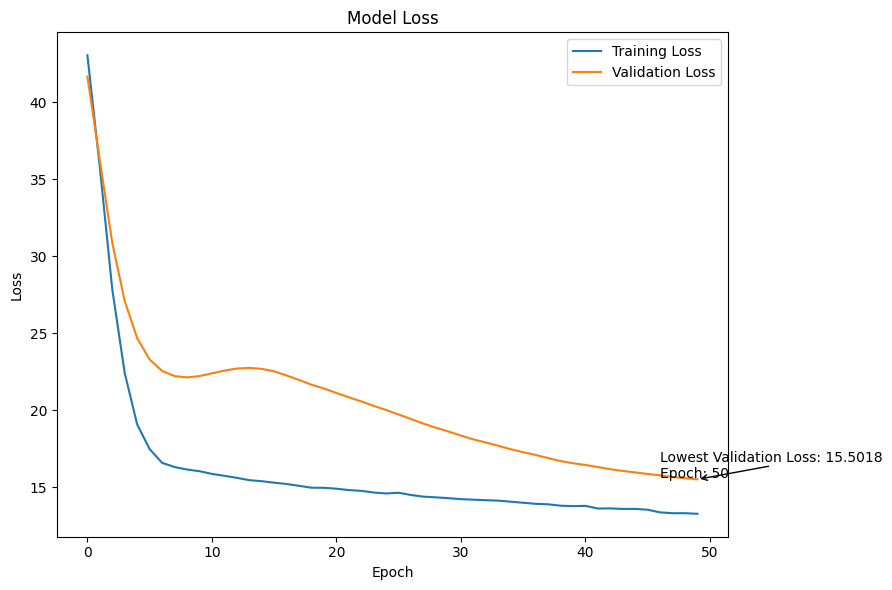

In [ ]:
# Find the epoch with the lowest validation loss
best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))


# Plot training history without accuracy
def plot_training_history(history, best_epoch):
    plt.figure(figsize=(9, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Display the lowest validation loss and the epoch at which it occurred
    min_val_loss = min(history.history['val_loss'])
    plt.annotate(
        f'Lowest Validation Loss: {min_val_loss:.4f}\nEpoch: {best_epoch + 1}',
        xy=(best_epoch, min_val_loss),
        xytext=(best_epoch - 3, min_val_loss + 0.1),  # Adjust text position
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )

    plt.tight_layout()
    plt.show()


plot_training_history(history, best_epoch)